In [1]:
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib as plt
import seaborn as sns

In [2]:
file_path = "./Count_Statistics_2022_Trimmed_CSV.csv"
data = pd.read_csv(file_path)

# Display the first few rows
# print(data.head())


In [3]:
# Select relevant features
features = ["REGION", "COUNTY_FIPS", "COUNT_STATS_ID", "AADT"]

# Drop rows with missing values
df = data[features].dropna()

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df[["AADT"]])  # Use raw AADT before transformation

df["AADT_log"] = np.log1p(df["AADT"])  # log(1 + AADT) avoids log(0)

# Now apply StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["AADT_log"]])

# Normalize numerical features
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df)

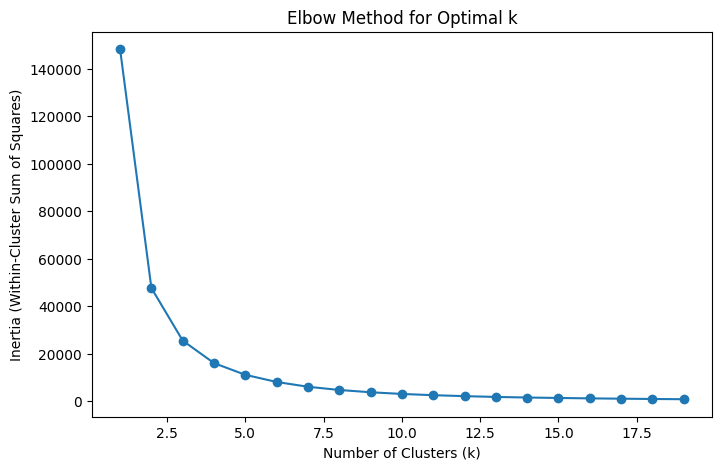

In [4]:
import matplotlib.pyplot as plt

# Range of cluster numbers to test
k_values = range(1, 20)
inertia = []

# Run K-Means with different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)  # Ensure data is normalized/scaled before clustering
    inertia.append(kmeans.inertia_)  # Store the inertia

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [5]:
# Define number of clusters (test different values with Elbow Method)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit clustering model
df["Cluster"] = kmeans.fit_predict(df_scaled)

In [6]:
print(df["Cluster"].value_counts())

# plt.scatter(df["AADT"], df["SPEED_LIMIT"], c=df["Cluster"], cmap="viridis")
# plt.xlabel("AADT")
# plt.ylabel("Speed Limit")
# plt.title("Traffic Clustering")
# plt.show()

Cluster
2    49385
0    41168
1    36083
3    21593
Name: count, dtype: int64


In [7]:
cluster_summary = df.groupby(["Cluster"])["AADT"].mean()
print(cluster_summary)

Cluster
0      280.870118
1    12259.552199
2     1687.276359
3       43.073913
Name: AADT, dtype: float64


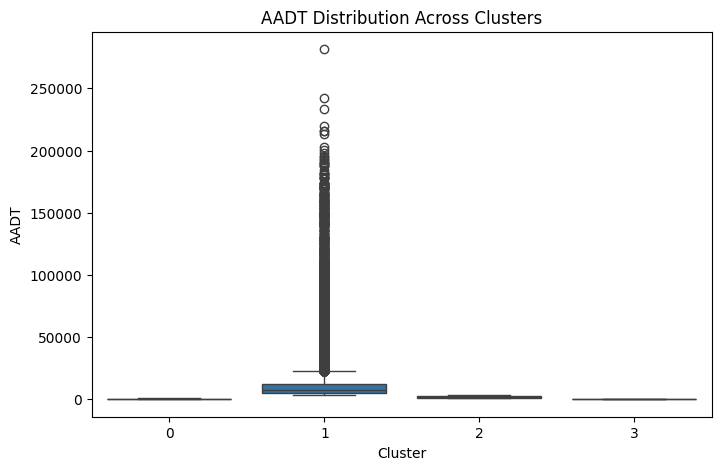

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Cluster"], y=df["AADT"])
plt.xlabel("Cluster")
plt.ylabel("AADT")
plt.title("AADT Distribution Across Clusters")
plt.show()


In [9]:
# Group by 'Cluster' and get value counts for 'COUNTY_FIPS'
top_3_per_cluster = (
    df.groupby("Cluster")["COUNTY_FIPS"]
    .value_counts()
    .groupby(level=0)
    .head(3)  # Get top 3 per cluster
)

print(top_3_per_cluster)


Cluster  COUNTY_FIPS
0        59.0           2774
         103.0          2535
         29.0           1621
1        103.0          3757
         59.0           3175
         29.0           2997
2        29.0           3336
         103.0          3190
         59.0           3019
3        103.0          1553
         119.0          1092
         59.0            993
Name: count, dtype: int64


In [10]:
# Describe AADT counts per cluster
df.groupby("Cluster")["AADT"].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,41168.0,280.870118,143.799289,90.0,155.0,250.0,389.0,598.0
1,36083.0,12259.552199,17272.077524,3521.0,4834.0,7059.0,11899.5,281466.0
2,49385.0,1687.276359,820.635669,599.0,970.0,1514.0,2308.0,3520.0
3,21593.0,43.073913,24.851461,0.0,22.0,42.0,64.0,89.0


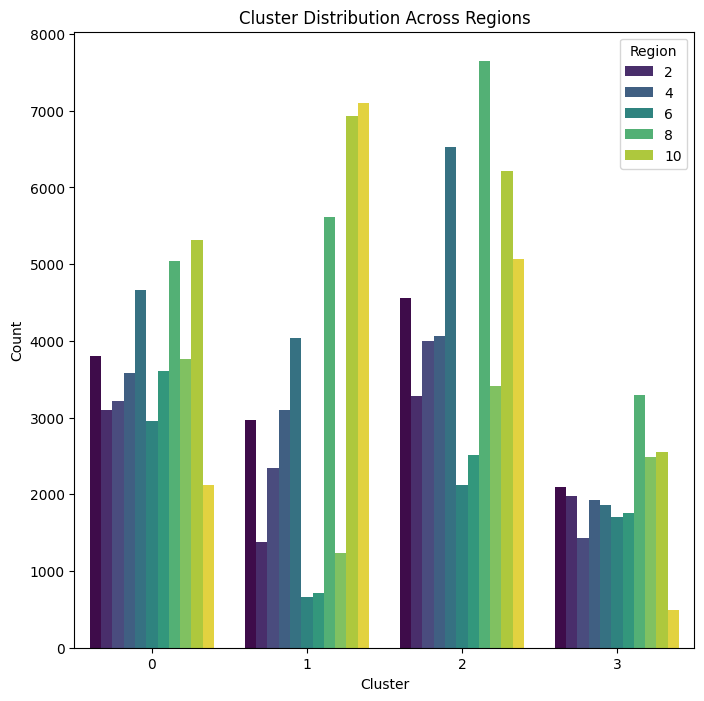

In [11]:
import matplotlib.pyplot as plt

df["REGION"] = df["REGION"].astype(int)  # Ensure REGION is an integer

plt.figure(figsize=(8, 8))
sns.countplot(x="Cluster", hue="REGION", data=df, palette="viridis")

plt.title("Cluster Distribution Across Regions")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Region")
plt.show()

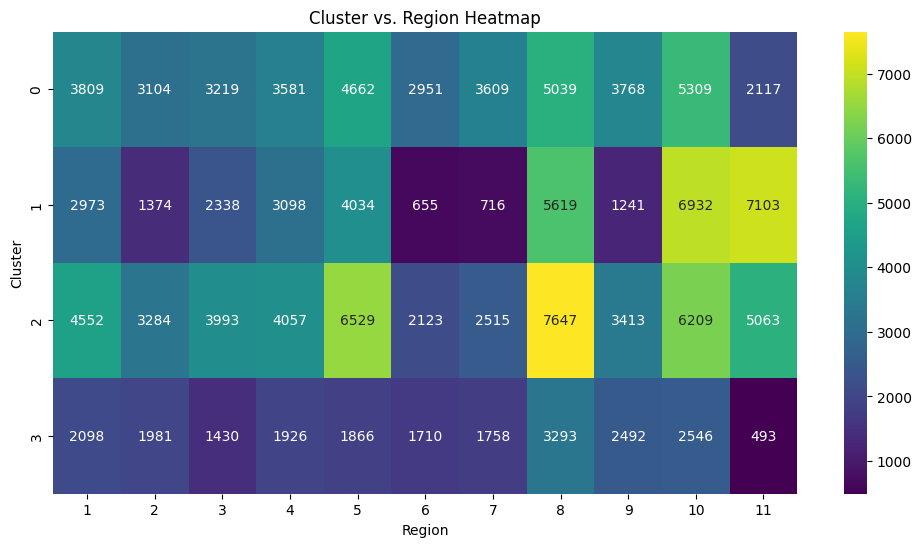

In [12]:


cluster_region_pivot = df.pivot_table(index="Cluster", columns="REGION", aggfunc="size", fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_region_pivot, cmap="viridis", annot=True, fmt="d")

plt.title("Cluster vs. Region Heatmap")
plt.xlabel("Region")
plt.ylabel("Cluster")
plt.show()


In [13]:
df[["REGION", "COUNTY_FIPS", "COUNT_STATS_ID", "AADT", "Cluster"]].to_csv("kmeans_results.csv", index=False)
